In [104]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import sys, string, os
import subprocess
import latex

In [66]:
class Rain_random_graph:
    def __init__(self, p: float = None, bound: int = None, time: int = -1):
        self.time = time
        self.p = p
        self.bound = bound
        self.H = []
        self.clients = []
        self.edges = []
        if self.time != -1 and self.time > 0:
            self.clients = [np.random.binomial(1, self.p, 2*self.bound + 1) for _ in range(self.time)]
            self.edges = [np.full(2*self.bound + 1, None) for _ in range(self.time)]
            for i in range(1, self.time+1):
                for j in range(2*bound+1):
                    self.generate_node_edges([j, i])
            self.H = [np.full(2*self.bound + 1, None) for _ in range(time)]
        self.arrow_width = 0.001
        self.arrow_head_width = 0.2
        self.arrow_head_length = 0.2
        self.EPS = 0.23
        self.exec_file = "/Users/aleksandrrezler/Downloads/rrg_fixed_size/rrg_fixed_size/build-Debug/bin/rrg_fixed_size"
        self.moduled_data = "/Users/aleksandrrezler/Downloads/rrg_moduled_data"
                        
    def generate_node_edges(self, grid_index: list):
        server = grid_index[0]
        time = grid_index[1] - 1
        node_edges = []      
        if not self.lazy:
            server = grid_index[0]
            time = grid_index[1] - 1
            if self.clients[time][server] == 0:
                node_edges = [None, None, None, None]
            else:
                if time > 0:
                    if server > 0:
                        if self.clients[time-1][server-1] == 1:
                            node_edges.append(1)
                        else:
                            node_edges.append(None)
                    else:
                        node_edges.append(None)
                        node_edges.append(None)
                    if server < 2*self.bound:
                        if self.clients[time-1][server+1] == 1:
                            node_edges.append(1)
                        else:
                            node_edges.append(None)
                        if self.clients[time][server+1] == 1:
                            node_edges.append(np.random.binomial(1, 0.5))
                        else:
                            node_edges.append(None)
                    else:
                        node_edges.append(None)
                        node_edges.append(None)
                else:
                    node_edges.append(None)
                    if server < 2*self.bound:
                        if self.clients[time][server+1] == 1:
                            node_edges.append(None)
                            node_edges.append(np.random.binomial(1, 0.5))
                        else:
                            node_edges.append(None)
                            node_edges.append(None)
                    else:
                        node_edges.append(None)
                        node_edges.append(None)
            self.edges[time][server] = node_edges
    
    def max_path(self, edge_coord: list = None)->int:
        if edge_coord is None:
            edge_coord = [self.bound, self.time-1]
        server = edge_coord[0]
        time = edge_coord[1]
        if time == -1:
            return 0
        else:
            max_edge_path_d = 0
            max_edge_path_l_u = 0
            max_edge_path_l_d = 0
            max_edge_path_r_d = 0
            max_edge_path_r_u = 0
            if self.H[time][server] is not None:
                return self.H[time][server]
            if time > 0:
                if self.clients[time-1][server] == 1:
                    if self.clients[time][server] == 1:
                        max_edge_path_d = self.max_path([server, time-1]) + 1
                    else:
                        max_edge_path_d = self.max_path([server, time-1])
                else:
                    if self.clients[time][server] == 1:
                        max_edge_path_d = self.max_path([server, time-1]) + 1
                    else:
                        max_edge_path_d = self.max_path([server, time-1])
                if server > 0 and self.edges[time][server-1][2] == 0:
                    max_edge_path_l_u = self.max_path([server-1, time]) + 1
                if self.edges[time][server][0] is not None:
                    max_edge_path_l_d = self.max_path([server-1, time-1]) + 1
                if self.edges[time][server][1] is not None:
                    max_edge_path_r_d = self.max_path([server+1, time-1]) + 1
                if self.edges[time][server][2] == 1:
                    max_edge_path_r_u = self.max_path([server+1, time]) + 1                   
                self.H[time][server] = max(max_edge_path_d,
                                   max_edge_path_l_u,
                                   max_edge_path_l_d,
                                   max_edge_path_r_d,
                                   max_edge_path_r_u)
                return self.H[time][server]
            else:
                if self.clients[time][server] == 1:
                    if not (server > 0 and self.edges[time][server-1][2] == 0) and not self.edges[time][server][2] == 1:
                        self.H[time][server] = 1
                        return self.H[time][server]
                    else:
                        max_edge_path_l_u = 0
                        max_edge_path_r_u = 0
                        if server > 0 and self.edges[time][server-1][2] == 0:
                            max_edge_path_l_u = self.max_path([server-1, time]) + 1
                        if self.edges[time][server][2] == 1:
                            max_edge_path_r_u = self.max_path([server+1, time]) + 1
                        self.H[time][server] = max(max_edge_path_l_u, max_edge_path_r_u)
                        return self.H[time][server]
                else:
                    self.H[time][server] = 0
                    return self.max_path([server, time-1])
    
    def draw_graph(self, max_path_coord: list = None):
        plt.rcParams['figure.figsize'] = [20, 10]
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_xticks(np.arange(-self.bound,self.bound+1,1))
        ax.set_yticks(np.arange(0,self.time+1,1))
        arrow_width = self.arrow_width
        arrow_head_width = self.arrow_head_width
        arrow_head_length = self.arrow_head_length
        EPS = self.EPS
        for i in range(2*self.bound+1):
            for j in range(self.time):
                if self.clients[j][i] == 1:
                    ax.plot([i - self.bound], [j+1], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="black")
                else:
                    ax.plot([i - self.bound], [j+1], marker="o", markersize=10, markeredgecolor="black", markerfacecolor="white")
        for i in range(2*self.bound+1):
            for j in range(self.time):
                pass
                if j != 0:
                    ax.arrow(i - self.bound, j+1, 0, -1, width = arrow_width, 
                          head_width = 0, head_length=0, overhang = 1, ec ='blue')
                if self.edges[j][i][0] is not None:
                    ax.arrow(i - self.bound, j+1, -1, -1, width = arrow_width, 
                              head_width = 0, head_length=0, overhang = 1, ec ='blue')
                if self.edges[j][i][1] is not None:
                    ax.arrow(i - self.bound, j+1, 1, -1, width = arrow_width, 
                              head_width = 0, head_length=0, overhang = 1, ec ='blue')
                if self.edges[j][i][2] is not None:
                    if self.edges[j][i][2] == 1:
                        ax.arrow(i - self.bound, j+1, (1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length, overhang = 1, ec ='blue')
                    else:
                        ax.arrow(i - self.bound + 1, j+1, -(1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length, overhang = 1, ec ='blue')
                        
        if max_path_coord is not None:
            self.max_path([max_path_coord[0] + self.bound, max_path_coord[1] - 1])
            server = max_path_coord[0] + self.bound
            time = max_path_coord[1] - 1
            while time >= 0:
                if server > 0 and self.edges[time][server-1][2] == 0 and self.H[time][server-1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, -(1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server - 1
                    continue
                if server > 0 and time > 0 and self.edges[time][server][0] is not None and self.H[time-1][server-1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, -(1 - EPS), -(1 - EPS), width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server - 1
                    time = time - 1
                    continue
                if server < 2*self.bound and time > 0 and self.edges[time][server][1] is not None and self.H[time-1][server+1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, (1 - EPS), -(1 - EPS), width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server + 1
                    time = time - 1
                    continue
                if server < 2*self.bound and self.edges[time][server][2] is not None and self.H[time][server+1] == self.H[time][server] - 1:
                    ax.arrow(server - self.bound, time+1, (1 - EPS), 0, width = arrow_width, 
                                  head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    server = server + 1
                    continue
                if time > 0:
                    ax.arrow(server - self.bound, time+1, 0, -(1 - 1.2*EPS), width = arrow_width, 
                    head_width = arrow_head_width, head_length=arrow_head_length/4, overhang = 4, ec ='red')
                    time = time - 1
                    continue
                time = time - 1
                
        plt.show()   
    
    def f_max_paths(self, verbose=False)->dict:
        process = subprocess.Popen(self.exec_file, stdout=subprocess.PIPE)
        if verbose:
            for line in iter(process.stdout.readline, b''):
                sys.stdout.write(line)
        
        return self.get_f_data()
    
    def get_f_data(self)->dict:
        rrg_data = dict()
        rrg_data_files = os.listdir(self.moduled_data)
        for file in rrg_data_files:
            if (file.endswith('.txt')):
                with open(self.moduled_data + '/' + file, 'r', encoding= 'unicode_escape') as f:
                    rrg_data_list = f.readline().split(',')
                    rrg_data[file] = list(map(int, rrg_data_list[:len(rrg_data_list)-1]))
        
        return rrg_data
    


In [49]:
rrg = Rain_random_graph()
rrg_data = rrg.f_max_paths(verbose=True)

Iteration: 1
29014
Iteration: 2
29026
Iteration: 3
29020
Iteration: 4
29005
Iteration: 5
29043
Iteration: 6
29039
Iteration: 7
29047
Iteration: 8
29052
Iteration: 9
29034
Iteration: 10
29002
Iteration: 11
29035
Iteration: 12
29013
Iteration: 13
29051
Iteration: 14
29023
Iteration: 15
29018
Iteration: 16
28963
Iteration: 17
29039
Iteration: 18
29002
Iteration: 19
28982
Iteration: 20
28986
Iteration: 21
29002
Iteration: 22
29026
Iteration: 23
29014
Iteration: 24
29047
Iteration: 25
29009
Iteration: 26
28988
Iteration: 27
29049
Iteration: 28
29022
Iteration: 29
29031
Iteration: 30
29073
Iteration: 31
29026
Iteration: 32
29023
Iteration: 33
29033
Iteration: 34
29019
Iteration: 35
29055
Iteration: 36
29047
Iteration: 37
29090
Iteration: 38
29047
Iteration: 39
29040
Iteration: 40
29023
Iteration: 41
29034
Iteration: 42
29020
Iteration: 43
29048
Iteration: 44
29056
Iteration: 45
29036
Iteration: 46
29041
Iteration: 47
29038
Iteration: 48
29030
Iteration: 49
28997
Iteration: 50
29047
Iteration

5498
Iteration: 10
5530
Iteration: 11
5463
Iteration: 12
5483
Iteration: 13
5462
Iteration: 14
5542
Iteration: 15
5477
Iteration: 16
5467
Iteration: 17
5508
Iteration: 18
5467
Iteration: 19
5501
Iteration: 20
5450
Iteration: 21
5487
Iteration: 22
5526
Iteration: 23
5528
Iteration: 24
5468
Iteration: 25
5431
Iteration: 26
5406
Iteration: 27
5487
Iteration: 28
5430
Iteration: 29
5467
Iteration: 30
5495
Iteration: 31
5523
Iteration: 32
5434
Iteration: 33
5422
Iteration: 34
5435
Iteration: 35
5491
Iteration: 36
5537
Iteration: 37
5488
Iteration: 38
5551
Iteration: 39
5515
Iteration: 40
5516
Iteration: 41
5478
Iteration: 42
5436
Iteration: 43
5507
Iteration: 44
5445
Iteration: 45
5505
Iteration: 46
5495
Iteration: 47
5422
Iteration: 48
5553
Iteration: 49
5432
Iteration: 50
5516
Iteration: 51
5440
Iteration: 52
5518
Iteration: 53
5462
Iteration: 54
5532
Iteration: 55
5557
Iteration: 56
5436
Iteration: 57
5434
Iteration: 58
5487
Iteration: 59
5435
Iteration: 60
5453
Iteration: 61
5415
Iterati

In [220]:
rrg = Rain_random_graph()
rrg_data = rrg.get_f_data()
rrg_data = {k: np.array(v) for k, v in rrg_data.items()}
rrg_data

{'rrg_data_09_5000.txt': array([18035, 18043, 18049, 18058, 18084, 18048, 18069, 18068, 18050,
        18036, 18064, 18058, 18060, 18043, 18074, 18066, 18022, 18103,
        18067, 18020, 18093, 18053, 18067, 18058, 18066, 18073, 18077,
        18038, 18093, 18078, 18024, 18046, 18046, 18046, 18008, 18059,
        18033, 18060, 18055, 18040, 18061, 18055, 18089, 18079, 18102,
        18044, 18054, 18047, 18061, 18056, 18037, 18046, 18056, 18039,
        18019, 18069, 18072, 18032, 18031, 18027, 18057, 18047, 18042,
        18064, 18051, 18012, 18065, 18072, 18053, 18031, 18068, 18056,
        18060, 18077, 18038, 18035, 18059, 18075, 18085, 18075, 18042,
        18079, 18095, 18052, 18056, 18090, 18075, 18123, 18051, 18033,
        18017, 18034, 18028, 18046, 18042, 18068, 18053, 18056, 18065,
        18064]),
 'rrg_data_08_5000.txt': array([16630, 16630, 16666, 16643, 16681, 16708, 16601, 16631, 16681,
        16622, 16624, 16649, 16667, 16671, 16614, 16631, 16633, 16638,
        1666

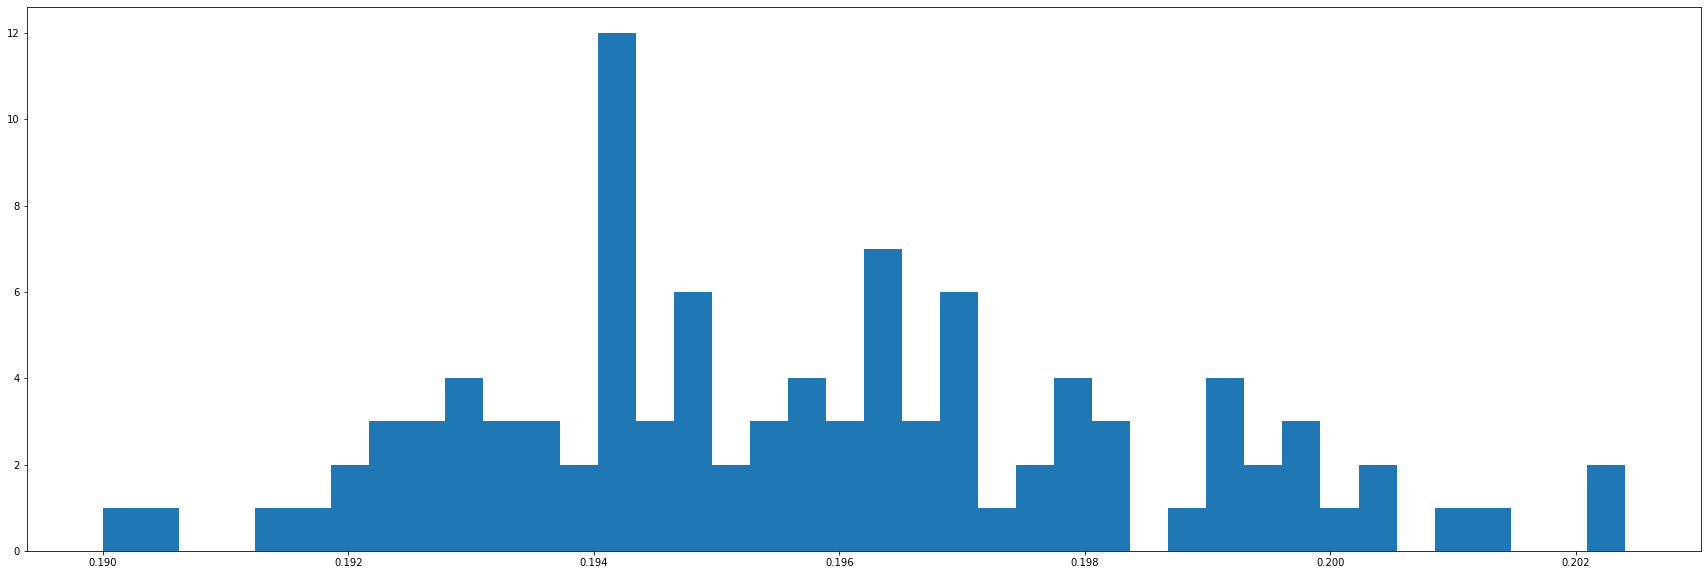

In [37]:
data_p_t = rrg_data['rrg_data_01_10000.txt']

plt.figure(figsize=(30, 10))
plt.hist(data_p_t / 10000, bins=40)
plt.show()

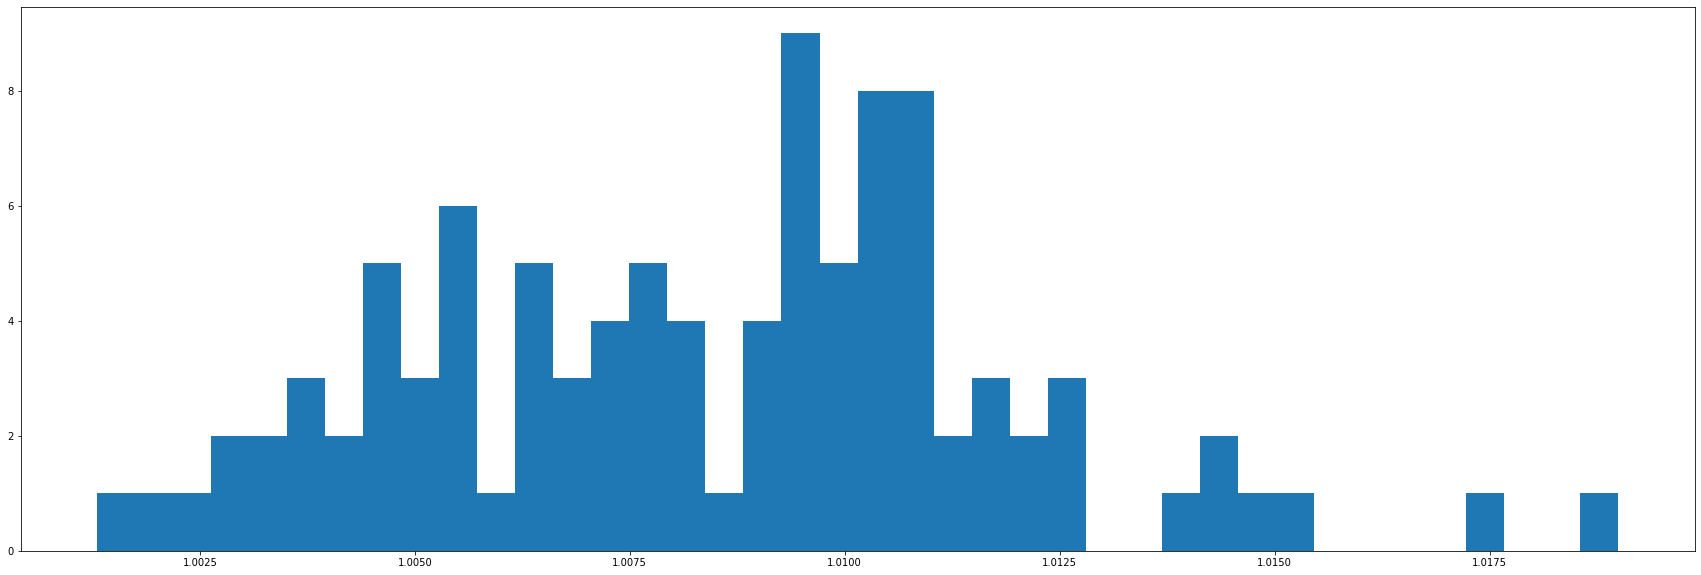

In [38]:
data_p_t = rrg_data['rrg_data_03_10000.txt']

plt.figure(figsize=(30, 10))
plt.hist(data_p_t / 10000, bins=40)
plt.show()

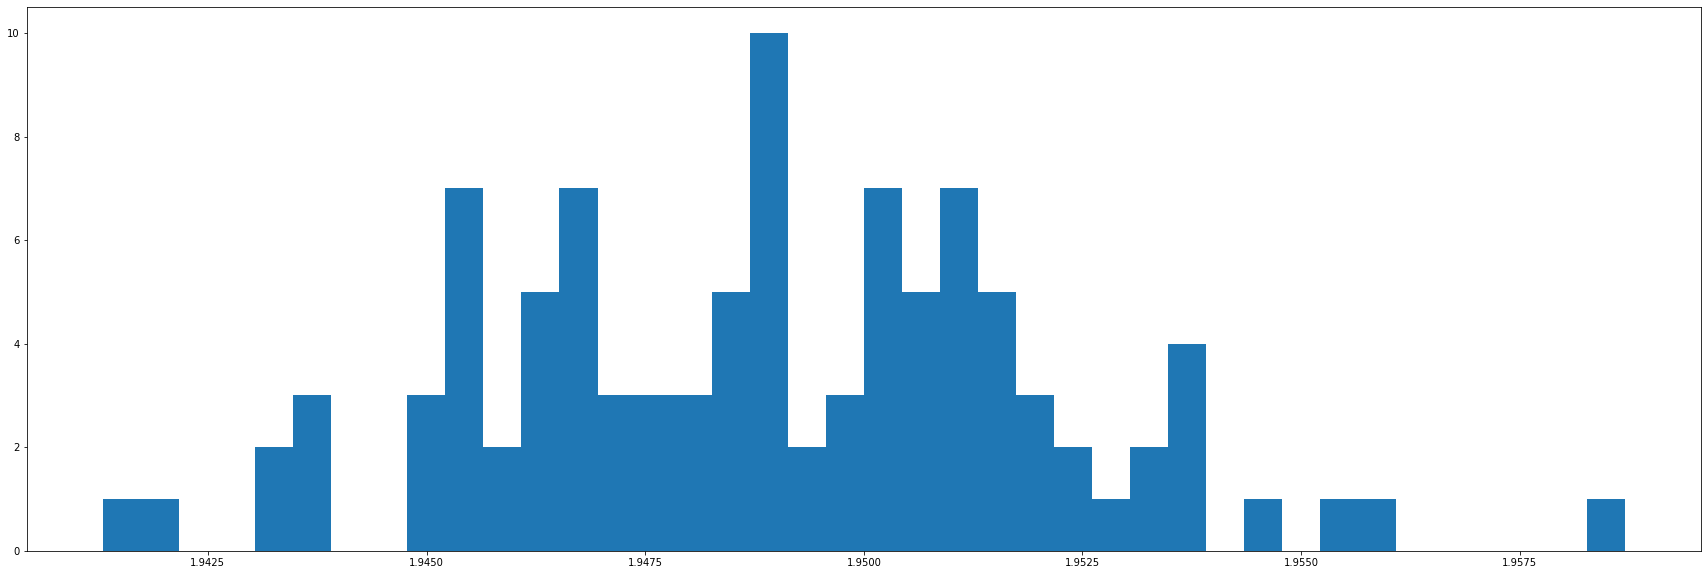

In [39]:
data_p_t = rrg_data['rrg_data_05_10000.txt']

plt.figure(figsize=(30, 10))
plt.hist(data_p_t / 10000, bins=40)
plt.show()

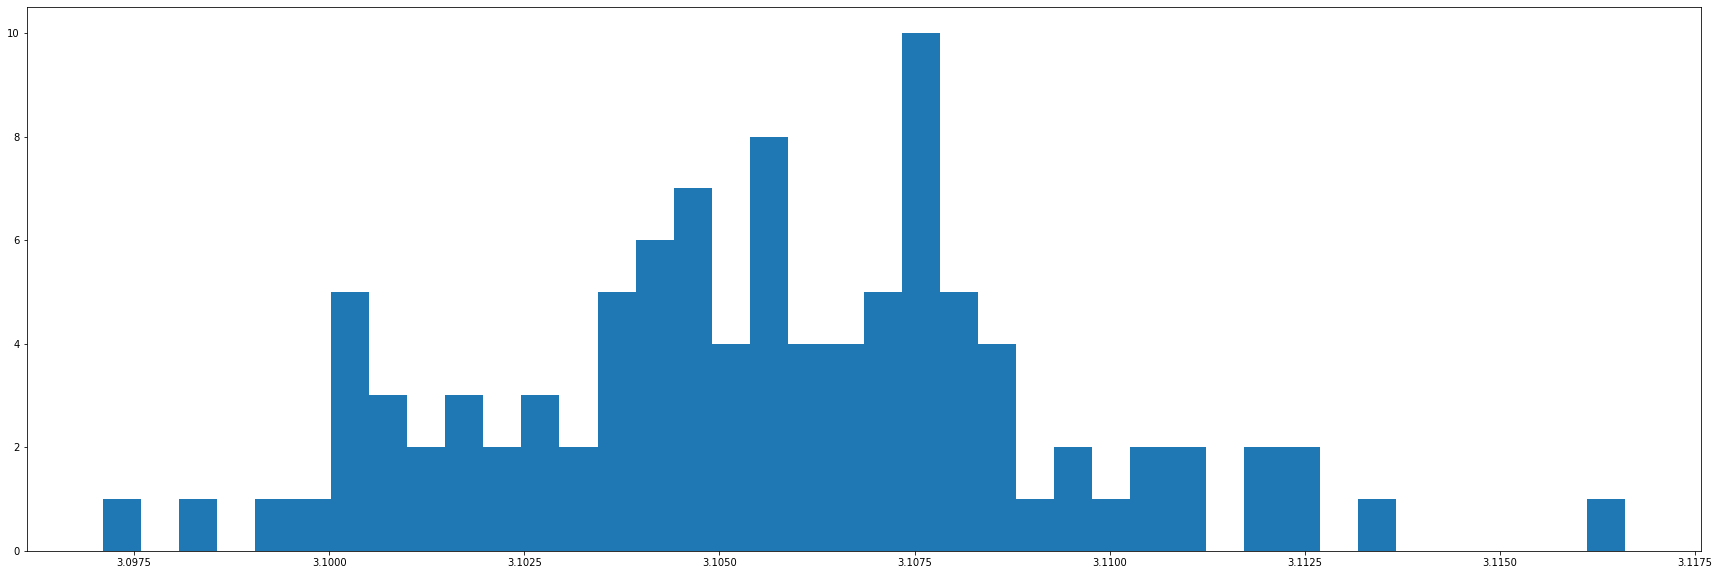

In [40]:
data_p_t = rrg_data['rrg_data_08_10000.txt']

plt.figure(figsize=(30, 10))
plt.hist(data_p_t / 10000, bins=40)
plt.show()

In [262]:
rrg_data.keys()

dict_keys(['rrg_data_09_5000.txt', 'rrg_data_08_5000.txt', 'rrg_data_06_2000.txt', 'rrg_data_07_2000.txt', 'rrg_data_06_10000.txt', 'rrg_data_03_5000.txt', 'rrg_data_02_5000.txt', 'rrg_data_04_1000.txt', 'rrg_data_05_1000.txt', 'rrg_data_005_5000.txt', 'rrg_data_005_1000.txt', 'rrg_data_07_10000.txt', 'rrg_data_095_2000.txt', 'rrg_data_01_10000.txt', 'rrg_data_01_2000.txt', 'rrg_data_005_10000.txt', 'rrg_data_09_1000.txt', 'rrg_data_08_1000.txt', 'rrg_data_04_5000.txt', 'rrg_data_05_5000.txt', 'rrg_data_03_1000.txt', 'rrg_data_02_1000.txt', 'rrg_data_04_10000.txt', 'rrg_data_09_10000.txt', 'rrg_data_095_5000.txt', 'rrg_data_01_5000.txt', 'rrg_data_07_1000.txt', 'rrg_data_06_1000.txt', 'rrg_data_02_10000.txt', 'rrg_data_05_2000.txt', 'rrg_data_04_2000.txt', 'rrg_data_05_10000.txt', 'rrg_data_08_2000.txt', 'rrg_data_09_2000.txt', 'rrg_data_07_5000.txt', 'rrg_data_06_5000.txt', 'rrg_data_01_1000.txt', 'rrg_data_08_10000.txt', 'rrg_data_02_2000.txt', 'rrg_data_03_2000.txt', 'rrg_data_03_10

In [266]:
if 'rrg_data_095_10000.txt' in rrg_data.keys(): 
    del rrg_data['rrg_data_095_10000.txt']

rrg_cp = dict()
for k, v in rrg_data.items():
    if '10000' in k:
        rrg_cp[int(k[10:12].replace('_', '0'))/100] = v
        
rrg_cn03 = dict()
for k, v in rrg_data.items():
    if '_03_' in k:
        rrg_cn03[int(k.split('.')[0].split('_')[-1])] = v
        
rrg_cn05 = dict()
for k, v in rrg_data.items():
    if '_05_' in k:
        rrg_cn05[int(k.split('.')[0].split('_')[-1])] = v
        
rrg_cn07 = dict()
for k, v in rrg_data.items():
    if '_07_' in k:
        rrg_cn07[int(k.split('.')[0].split('_')[-1])] = v
        
rrg_cn08 = dict()
for k, v in rrg_data.items():
    if '_08_' in k:
        rrg_cn08[int(k.split('.')[0].split('_')[-1])] = v

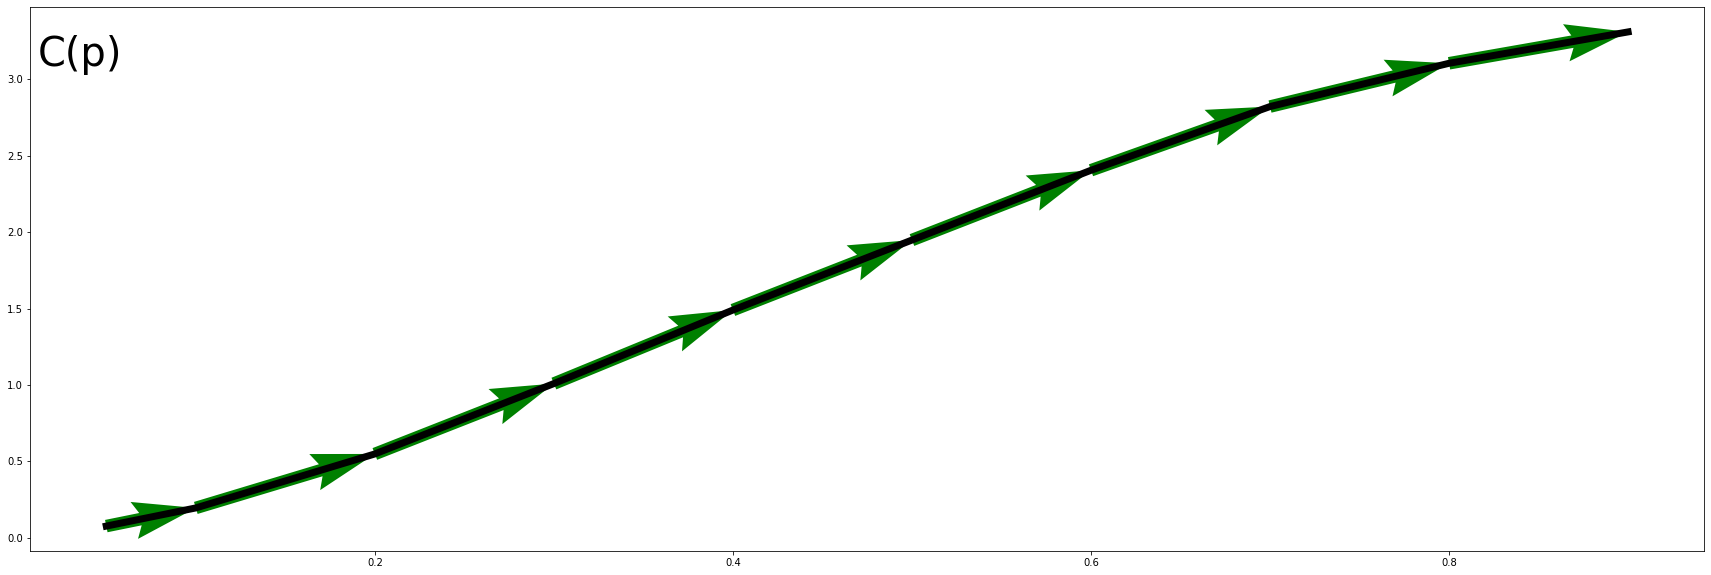

In [232]:
means = {k: v.mean()/10000 for k, v in rrg_cp.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
plt.figure(figsize=(30, 10))
plt.plot(x, y, linewidth=7.0, color='black')
plt.title('C(p)', fontsize=40, x=0.03, y=0.88)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.show()

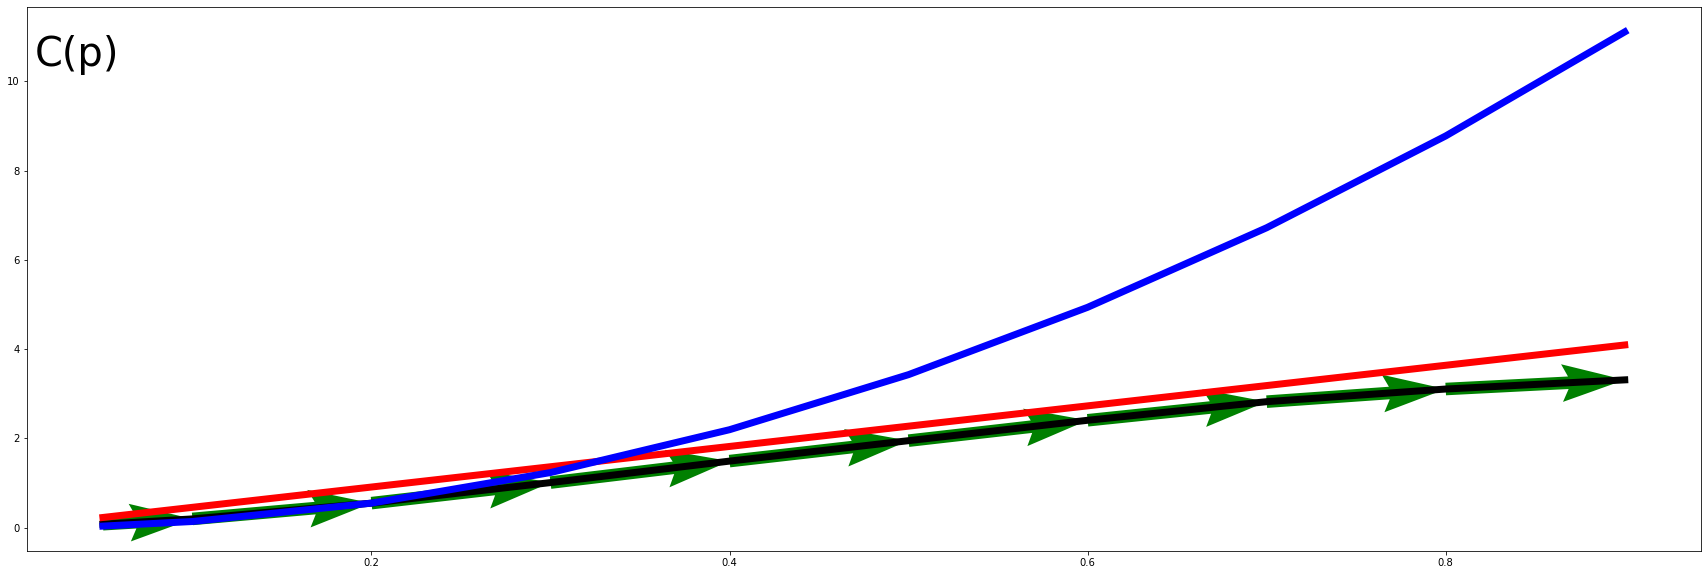

In [216]:
means = {k: v.mean()/10000 for k, v in rrg_cp.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
y_lin = np.array(derivatives[2:7]).mean() * x
y_sq = ( means[0.2] / 0.2**2 ) * x**2
plt.figure(figsize=(30, 10))
plt.plot(x, y, linewidth=7.0, color='black')
plt.plot(x, y_lin, linewidth=7.0, color='red')
plt.plot(x, y_sq, linewidth=7.0, color='blue')
plt.title('C(p)', fontsize=40, x=0.03, y=0.88)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.show()

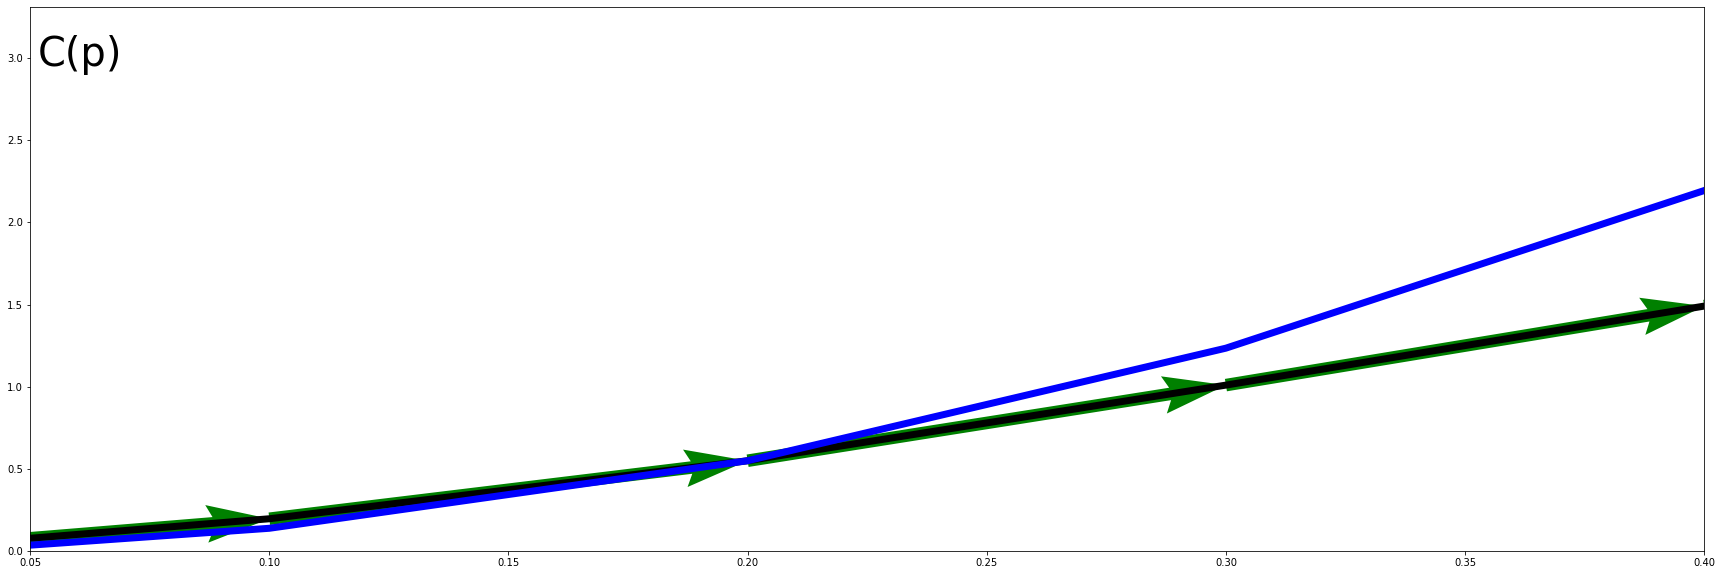

In [218]:
means = {k: v.mean()/10000 for k, v in rrg_cp.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
y_sq = ( means[0.2] / 0.2**2 ) * x**2
plt.figure(figsize=(30, 10))
plt.plot(x, y, linewidth=7.0, color='black')
plt.plot(x, y_sq, linewidth=7.0, color='blue')
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.title('C(p)', fontsize=40, x=0.03, y=0.88)
plt.axis([x[0], x[4], 0, y[len(y)-1]])
plt.show()

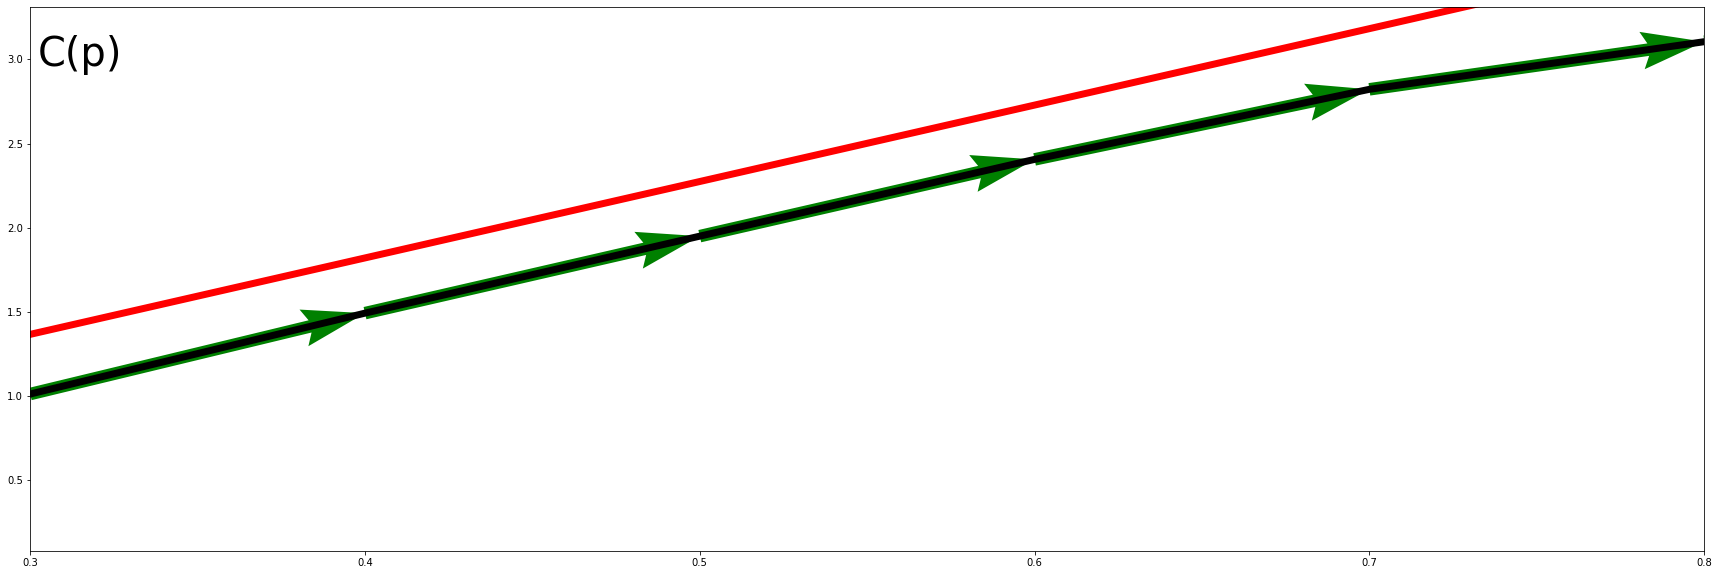

In [219]:
derivatives = []
for i in range(len(means)-1):
    derivatives.append( (y[i+1]-y[i]) / (x[i+1]-x[i]) )
means = {k: v.mean()/10000 for k, v in rrg_cp.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
y_lin = np.array(derivatives[2:7]).mean() * x
plt.figure(figsize=(30, 10))
plt.plot(x, y, linewidth=7.0, color='black')
plt.plot(x, y_lin, linewidth=7.0, color='red')
plt.title('C(p)', fontsize=40, x=0.03, y=0.88)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.axis([x[3], x[8], y[0], y[len(y)-1]])
plt.show()

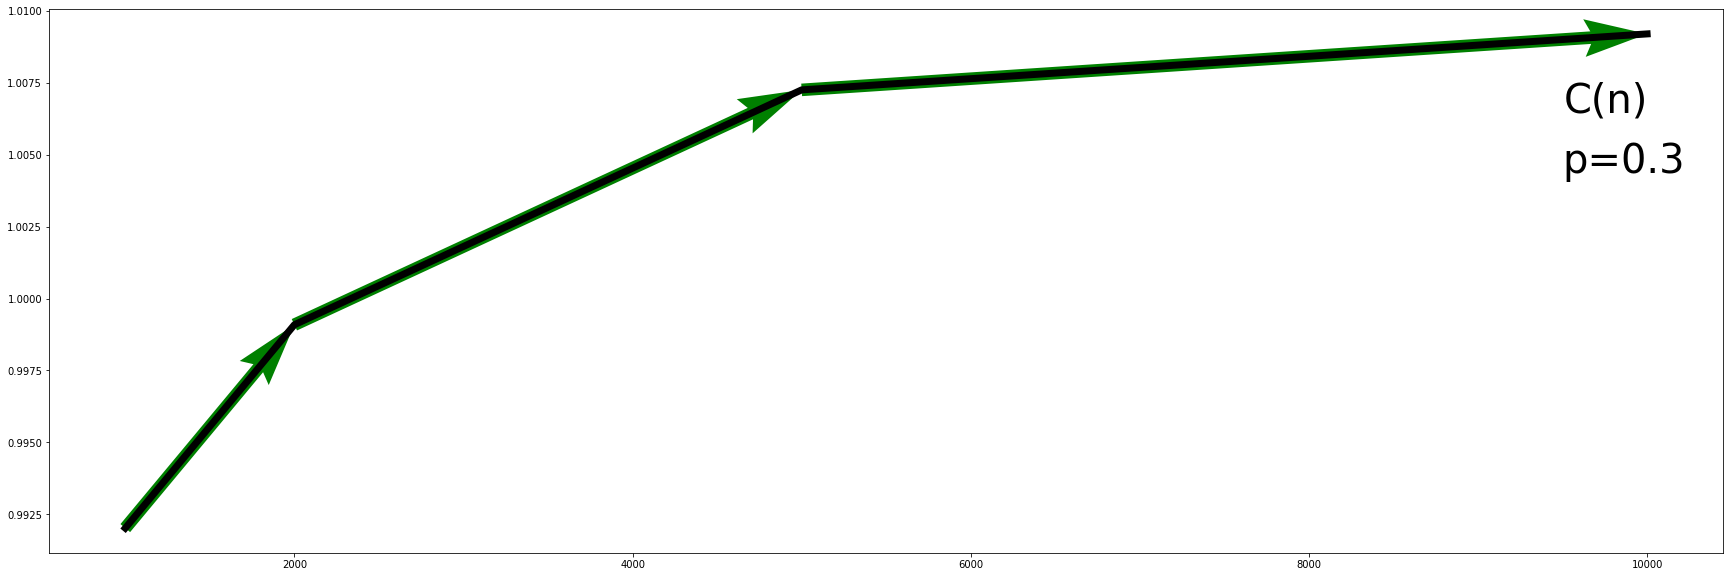

In [305]:
fig, ax = plt.subplots(figsize=(30, 10))
means = {k: v.mean()/k for k, v in rrg_cn03.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
ax.plot(x, y, linewidth=7.0, color='black')
ax.set_title('C(n)', fontsize=40, x=0.93, y=0.8)
plt.text(s='p=0.3', fontsize=40, x=0.904, y=0.7, transform=ax.transAxes)
ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.show()

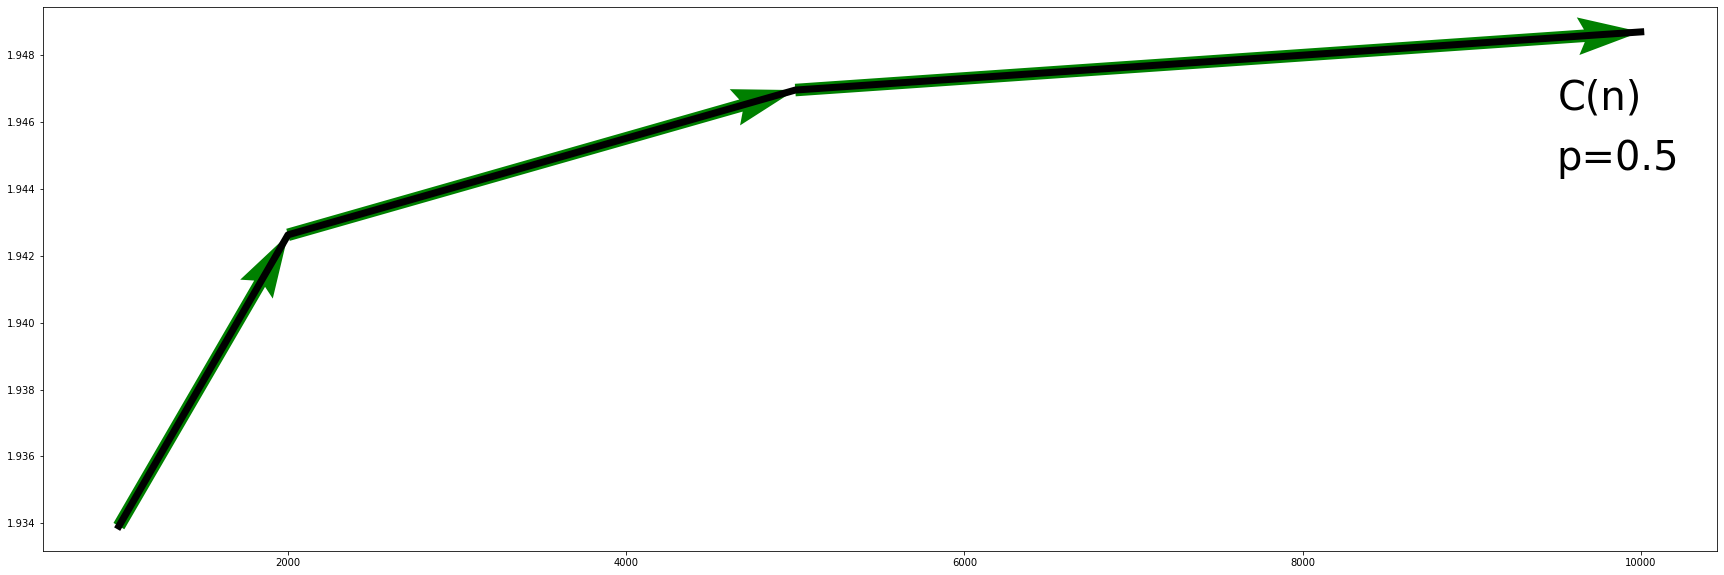

In [306]:
fig, ax = plt.subplots(figsize=(30, 10))
means = {k: v.mean()/k for k, v in rrg_cn05.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
ax.plot(x, y, linewidth=7.0, color='black')
ax.set_title('C(n)', fontsize=40, x=0.93, y=0.8)
plt.text(s='p=0.5', fontsize=40, x=0.904, y=0.7, transform=ax.transAxes)
ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.show()

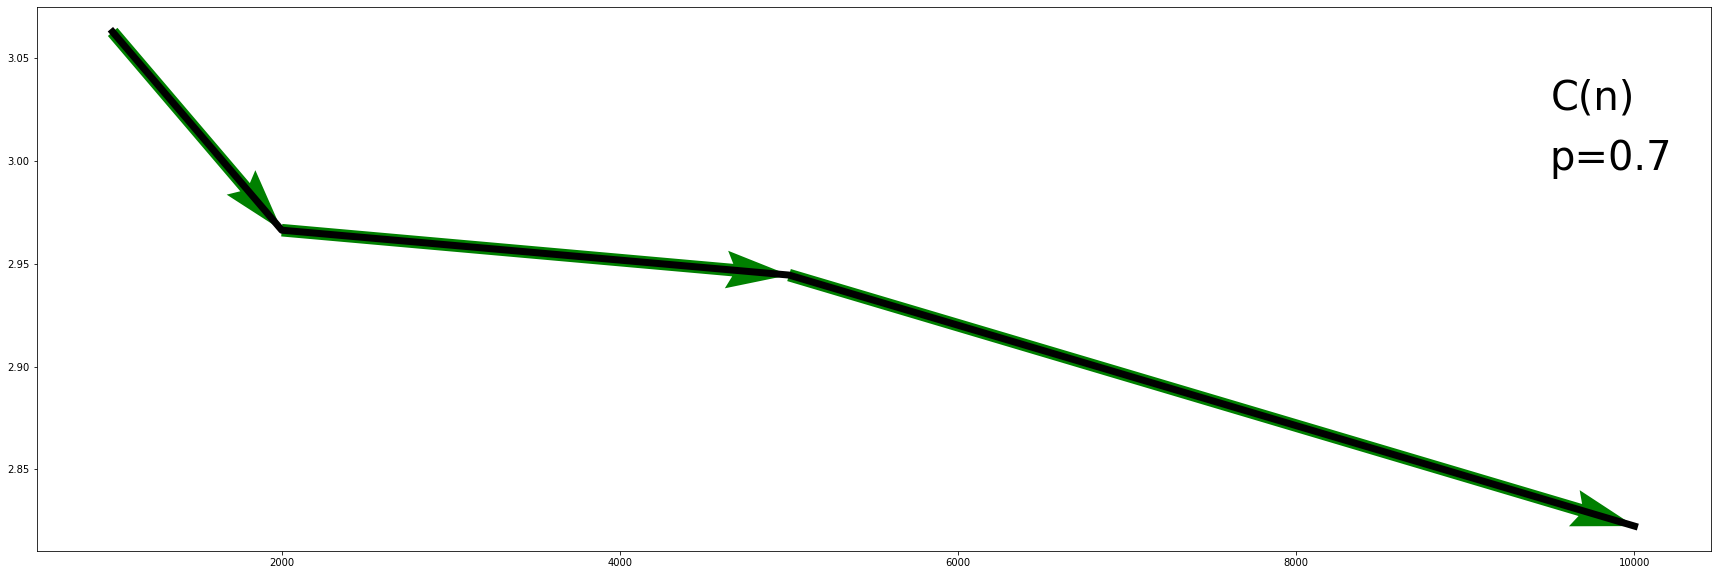

In [307]:
fig, ax = plt.subplots(figsize=(30, 10))
means = {k: v.mean()/k for k, v in rrg_cn07.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
ax.plot(x, y, linewidth=7.0, color='black')
ax.set_title('C(n)', fontsize=40, x=0.93, y=0.8)
plt.text(s='p=0.7', fontsize=40, x=0.904, y=0.7, transform=ax.transAxes)
ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.show()

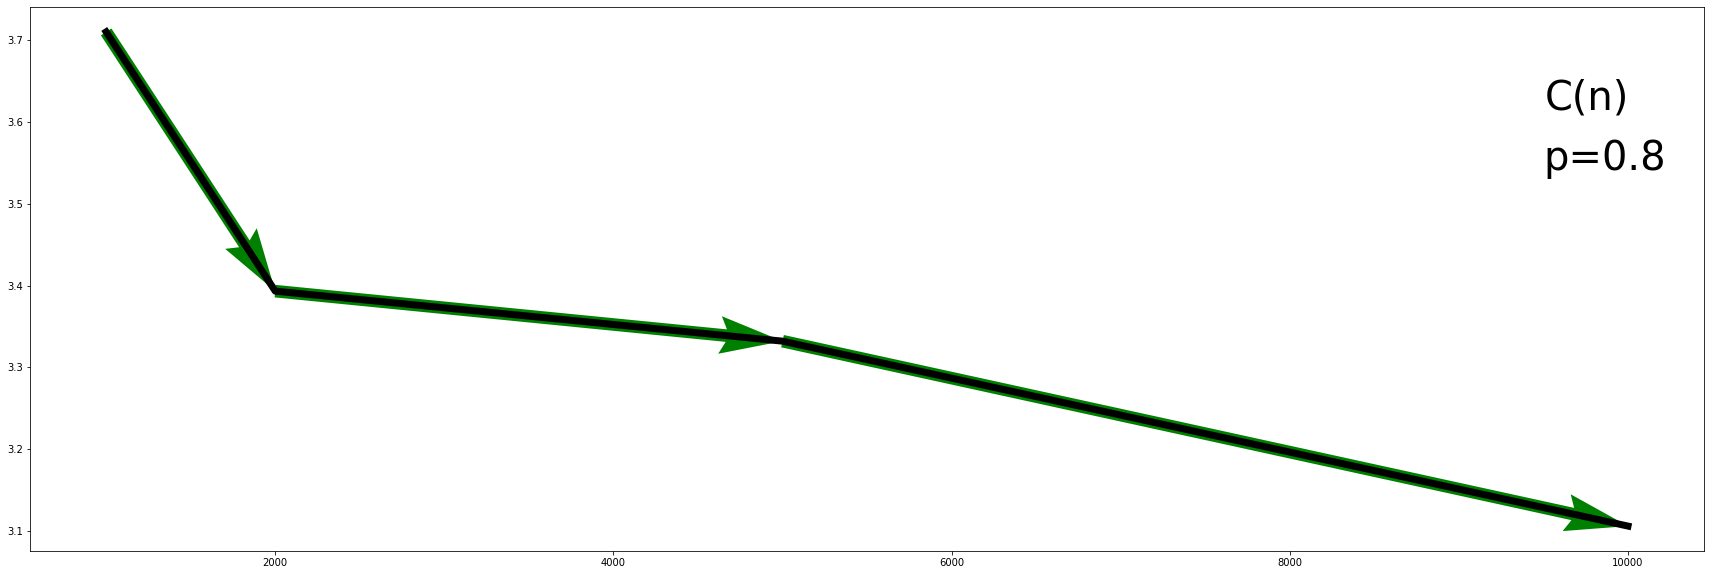

In [308]:
fig, ax = plt.subplots(figsize=(30, 10))
means = {k: v.mean()/k for k, v in rrg_cn08.items()}
lists = sorted(means.items())
x, y = zip(*lists)
x = np.array(x)
y = np.array(y)
ax.plot(x, y, linewidth=7.0, color='black')
ax.set_title('C(n)', fontsize=40, x=0.93, y=0.8)
plt.text(s='p=0.8', fontsize=40, x=0.904, y=0.7, transform=ax.transAxes)
ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='green')
plt.show()

In [272]:
# {k: v.mean()/k for k, v in rrg_cn05.items()}
rrg_cn05

{1000: array([1927, 1912, 1951, 1925, 1929, 1913, 1955, 1913, 1945, 1957, 1907,
        1917, 1933, 1927, 1951, 1936, 1948, 1939, 1947, 1928, 1894, 1941,
        1921, 1937, 1932, 1932, 1926, 1945, 1946, 1891, 1949, 1917, 1997,
        1928, 1946, 1949, 1958, 1956, 1914, 1914, 1929, 1925, 1936, 1935,
        1931, 1915, 1939, 1947, 1943, 1948, 1939, 1929, 1934, 1945, 1933,
        1936, 1922, 1964, 1946, 1950, 1930, 1927, 1936, 1917, 1946, 1916,
        1942, 1898, 1934, 1929, 1909, 1938, 1940, 1937, 1919, 1934, 1926,
        1933, 1938, 1931, 1925, 1938, 1943, 1915, 1920, 1948, 1948, 1919,
        1943, 1942, 1933, 1943, 1914, 1935, 1963, 1932, 1954, 1918, 1943,
        1937]),
 5000: array([9744, 9782, 9765, 9757, 9743, 9739, 9760, 9730, 9758, 9752, 9745,
        9745, 9757, 9776, 9753, 9734, 9777, 9736, 9714, 9724, 9701, 9745,
        9777, 9721, 9742, 9713, 9726, 9760, 9748, 9720, 9719, 9736, 9776,
        9754, 9767, 9730, 9727, 9756, 9674, 9703, 9719, 9763, 9767, 9700,
        97